In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
from __future__ import division
import matplotlib
import numpy as np
from pylab import *
import os
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4)})
plotStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
np.seterr(divide='ignore',invalid='ignore')
pass

### Setup the notebook.

In [79]:
import h5py
import math
testNames=[
           "first_order_decay_time_limit",
           "first_order_decay_time_limit_nrm",
           "first_order_decay_time_limit_degree_advancement",
           "first_order_decay_lower_species_limit",
           "first_order_decay_fpt_tracking",
           "first_order_decay_order_parameter",
           "first_order_decay_multiple_work_units",
           "first_order_decay_species_barrier",
           "first_order_decay_order_parameter_barrier_0",
           "first_order_decay_order_parameter_barrier_1",
          ]
test_names_bash_list=" ".join(testNames)
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

In [80]:
%%bash
rm -rf tmp && mkdir tmp

### Execute the simulations.

In [81]:
%%bash -s "$test_names_bash_list"
sbmlFilename="first_order_decay.sbml"
for testName in $1; do
    outputFilename=tmp/${testName}.lm
    rm -f ${outputFilename}* && lm_sbml_import ${outputFilename} ${sbmlFilename} > ${outputFilename}.import.log
    if [ ${testName} == "first_order_decay_time_limit" ]; then
        lm_setp ${outputFilename} writeInterval=1e-2 maxTime=1e1 > /dev/null
        solver="lm::cme::GillespieDSolver"
    elif [ ${testName} == "first_order_decay_time_limit_nrm" ]; then
        lm_setp ${outputFilename} writeInterval=1e-2 maxTime=1e1 > /dev/null
        solver="lm::cme::NextReactionSolver"
    elif [ ${testName} == "first_order_decay_time_limit_degree_advancement" ]; then
        lm_setp ${outputFilename} writeInterval=1e-2 maxTime=1e1 degreeAdvancementWriteInterval=1e-2 > /dev/null
        solver="lm::cme::GillespieDSolver"
    elif [ ${testName} == "first_order_decay_lower_species_limit" ]; then
        lm_setp ${outputFilename} writeInterval=1e-2 maxTime=1e1 "speciesLowerLimitList=0:150" > /dev/null
        solver="lm::cme::GillespieDSolver"
    elif [ ${testName} == "first_order_decay_fpt_tracking" ]; then
        lm_setp ${outputFilename} writeInterval=1e-2 maxTime=1e2 fptTrackingList=0 > /dev/null
        solver="lm::cme::GillespieDSolver"
    elif [ ${testName} == "first_order_decay_order_parameter" ]; then
        lm_setrm ${outputFilename} "OrderParameterCoefficients(0)=[-2.0]" "OrderParameterCoefficients=[1.0]" > /dev/null
        lm_setp ${outputFilename} writeInterval=1e-2 maxTime=1e1 orderParameterWriteInterval=1e-2 > /dev/null
        solver="lm::cme::GillespieDSolver"
    elif [ ${testName} == "first_order_decay_multiple_work_units" ]; then
        lm_setp ${outputFilename} writeInterval=1e-2 maxTime=1e1 stepsPerWorkUnit=100 > /dev/null
        solver="lm::cme::GillespieDSolver"
    elif [ ${testName} == "first_order_decay_species_barrier" ]; then
        lm_setp ${outputFilename} writeInterval=1e-2 maxTime=1e1 "speciesReflectingBarrierList=0:200" > /dev/null
        solver="lm::cme::GillespieDSolver"
    elif [ ${testName} == "first_order_decay_order_parameter_barrier_0" ]; then
        lm_setrm ${outputFilename} "OrderParameterCoefficients(0)=[-2.0]" "OrderParameterCoefficients=[1.0]" > /dev/null
        lm_setp ${outputFilename} writeInterval=1e-2 maxTime=1e1 orderParameterWriteInterval=1e-2 "orderParameterReflectingBarrierList=0:-400" > /dev/null
        solver="lm::cme::GillespieDSolver"
    elif [ ${testName} == "first_order_decay_order_parameter_barrier_1" ]; then
        lm_setrm ${outputFilename} "OrderParameterCoefficients(0)=[-2.0]" "OrderParameterCoefficients=[1.0]" > /dev/null
        lm_setp ${outputFilename} writeInterval=1e-2 maxTime=1e1 orderParameterWriteInterval=1e-2 "orderParameterReflectingBarrierList=1:200" > /dev/null
        solver="lm::cme::GillespieDSolver"
    else
        echo "Invalid test name: ${testName}"
    fi
    lmes -r 1-1000 -f ${outputFilename} -sl ${solver} > ${outputFilename}.simulate.log
done;
echo "Finished."

Finished.


### Spot check some simulations.

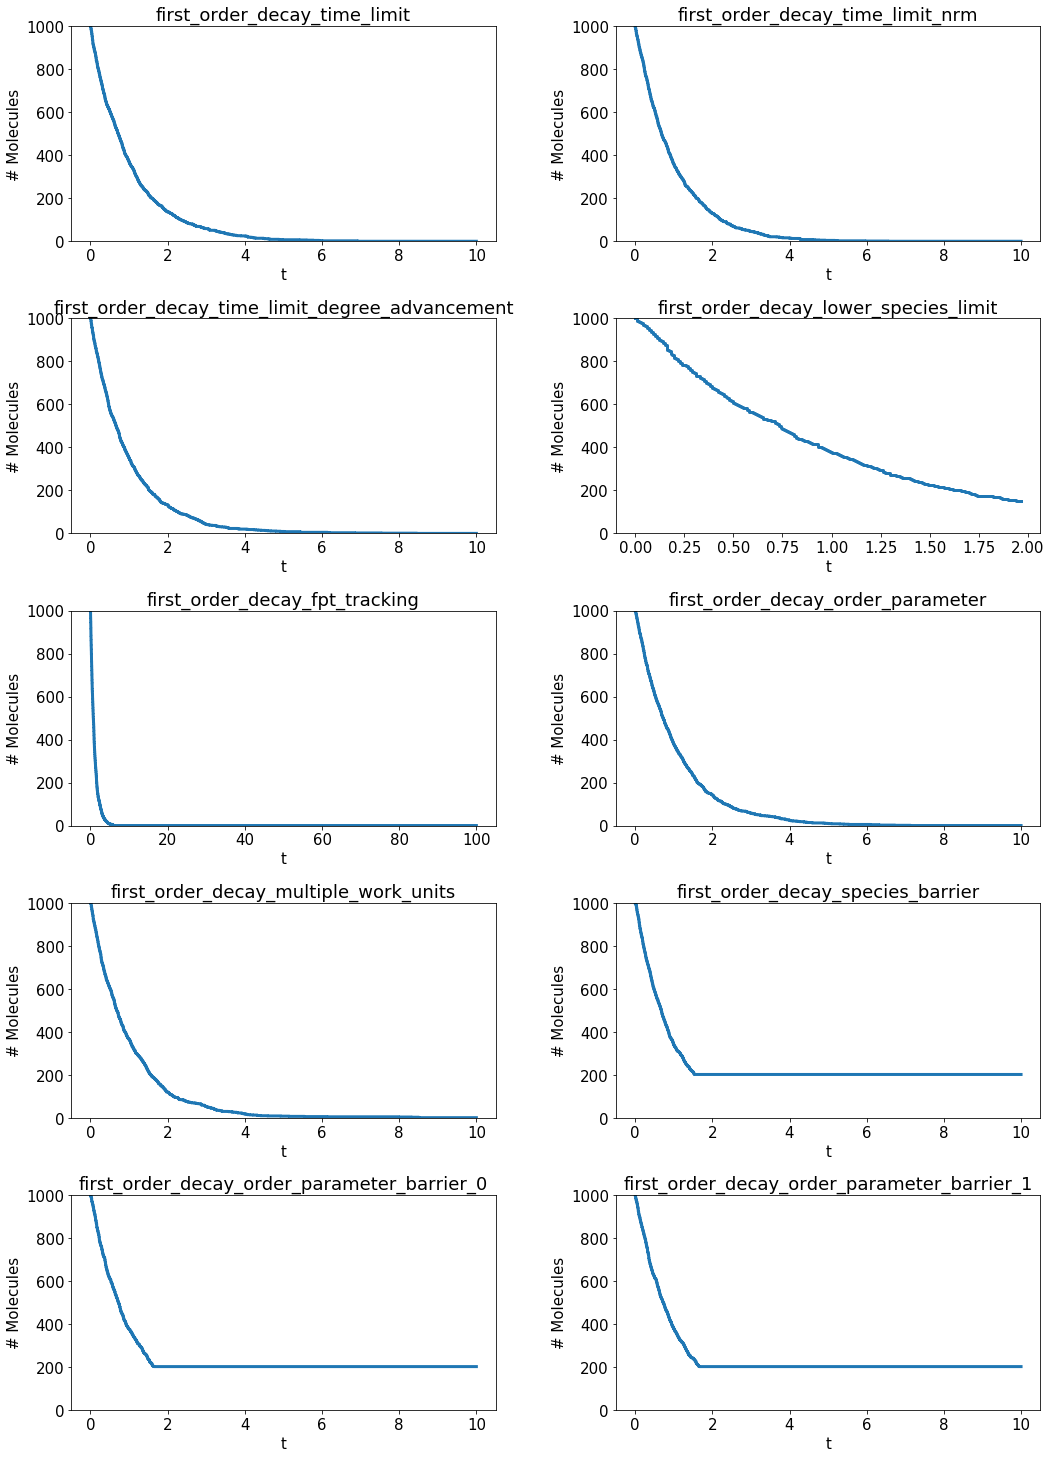

In [82]:
# Plot the time series for a single replicate.
for i,testName in enumerate(testNames):
    testOutputFilename="tmp/%s.lm"%(testName)
    fp = h5py.File(testOutputFilename, "r")
    cols=2
    rows=len(testNames)/cols+1
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,4*rows)})
    for replicate in (1,):
        counts=np.array(fp["/Simulations/%07d/SpeciesCounts"%replicate], dtype=double)
        times=np.array(fp["/Simulations/%07d/SpeciesCountTimes"%replicate], dtype=double)
        plt.subplot(rows,cols,i+1)
        step(times,counts[:,0], **stepStyles)
        xlabel('t'); ylabel('# Molecules'); ylim([0,1000]); title("%s"%(testName))
    fp.close()
tight_layout()
pass

### Define the tests.

In [83]:
def test_first_order_decay_time_limit(testOutputFilename):
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    k=0
    mSim=None
    vSim=None
    times=None
    for replicate in replicates:
        times = np.array(fp["/Simulations/%s/SpeciesCountTimes"%replicate], dtype=double)
        counts = np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        if times.shape != (1001,): raise Exception("invalid shape for times",times.shape)
        if counts.shape != (1001,1): raise Exception("invalid shape for counts",counts.shape)
        if not isclose(times[0],0.0,1e-6): raise Exception("invalid initial time",times[0])
        if not isclose(times[-1],10.0,1e-6): raise Exception("invalid final time",times[-1])
        if not isclose(counts[0],1000.0,1e-6): raise Exception("invalid initial count",times[0])
        if mSim is None:
            k += 1
            mSim = counts
            vSim = np.zeros(counts.shape, dtype=double)
        else:
            k += 1
            mSim = mSim + (counts-mSim)/k
            vSim = vSim + (counts-mSim)*(counts-mSim)
    vSim /= float((k-1))
    value = np.mean(mSim[-100:-1,0])

    A0=mSim[0]
    k=1.0
    mTheory=np.zeros(mSim.shape, dtype=double)
    mTheory[:,0]=A0*exp(-k*times)
    vTheory=np.zeros(vSim.shape, dtype=double)
    vTheory[:,0]=A0*exp(-k*times)*(1-exp(-k*times))
    
    # Plot the accuracy of the mean and variance.
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,6)})
    ax=plt.subplot(2,2,1)
    plt.plot(times,mSim, **plotStyles)
    plt.plot(times,mTheory, **plotStyles)
    ax.set_yscale('log'); xlabel('t'); ylabel('E{X(t)}'); title("%s"%(testOutputFilename))
    ax=plt.subplot(2,2,2)
    plt.plot(times,abs(mSim-mTheory)/mTheory, **plotStyles)
    ax.set_yscale('log'); ylim([1e-6,1e-1]); xlabel('t'); ylabel('Relative Error'); title("%s"%(testOutputFilename))
    ax=plt.subplot(2,2,3)
    plt.plot(times,vSim, **plotStyles)
    plt.plot(times,vTheory, **plotStyles)
    ax.set_yscale('log'); xlabel('t'); ylabel('Var{X(t)}'); title("%s"%(testOutputFilename))
    ax=plt.subplot(2,2,4)
    plt.plot(times,abs(vSim-vTheory)/vTheory, **plotStyles)
    ax.set_yscale('log'); ylim([1e-6,1e-0]); xlabel('t'); ylabel('Relative Error'); title("%s"%(testOutputFilename))
    fp.close()

    value = np.max(abs(mSim[0:len(mSim)//10]-mTheory[0:len(mSim)//10])/mTheory[0:len(mSim)//10])
    if value > 4e-3: raise Exception("max error in initial mean too large",value)
    value = np.mean(abs(mSim-mTheory)/mTheory)
    if value > 6e-2: raise Exception("mean error in mean too large",value)
    value = np.max(abs(vSim[1:]-vTheory[1:])/vTheory[1:])
    if value > 4e-1: raise Exception("max error in variance too large",value)        

In [84]:
def test_first_order_decay_time_limit_degree_advancement(testOutputFilename):
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    k=0
    mSim=None
    vSim=None
    times=None
    for replicate in replicates:
        if times is None:
            times = np.array(fp["/Simulations/%s/DegreeAdvancementTimes"%replicate], dtype=double)
        counts = np.array(fp["/Simulations/%s/DegreeAdvancementCounts"%replicate], dtype=double)
        if mSim is None:
            k += 1
            mSim = counts
            vSim = np.zeros(counts.shape, dtype=double)
        else:
            k += 1
            mSim = mSim + (counts-mSim)/k
            vSim = vSim + (counts-mSim)*(counts-mSim)
    vSim /= float((k-1))
    value = np.mean(mSim[-100:-1,0])

    A0=mSim[-1]
    k=1.0
    mTheory=np.zeros(mSim.shape, dtype=double)
    mTheory[:,0]=1000-A0*exp(-k*times)
    
    # Plot the accuracy of the mean and variance.
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,3)})
    ax=plt.subplot(1,2,1)
    plt.plot(times,mSim, **plotStyles)
    plt.plot(times,mTheory, **plotStyles)
    ax.set_yscale('log'); xlabel('t'); ylabel('E{X(t)}'); title("%s"%(testOutputFilename))
    ax=plt.subplot(1,2,2)
    plt.plot(times,abs(mSim-mTheory)/mTheory, **plotStyles)
    ax.set_yscale('log'); ylim([1e-6,1e-1]); xlabel('t'); ylabel('Relative Error'); title("%s"%(testOutputFilename))
    fp.close()

    value = np.mean(abs(mSim-mTheory)/mTheory)
    if value > 1e-2: raise Exception("mean error in mean too large",value)

In [85]:
def test_first_order_decay_lower_species_limit(testOutputFilename):
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    finalTimes=[]
    finalCounts=[]
    for replicate in replicates:
        counts = fp["/Simulations/%s/SpeciesCounts"%replicate]
        times = fp["/Simulations/%s/SpeciesCountTimes"%replicate]
        finalTimes.append(times[-1])
        finalCounts.append(counts[-1])
            
    # Plot the final times.
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (7.5,3)})
    hist(finalTimes,100)
    xlabel('Final Time'); ylabel('# Runs'); title("%s"%(testOutputFilename))
    fp.close()
    
    value = np.min(finalCounts)
    if value != 150: raise Exception("incorrect value for final count",value)
    value = np.max(finalCounts)
    if value != 150: raise Exception("incorrect value for final count",value)
    value = np.mean(finalTimes)
    if not isclose(value,1.9,1e-1): raise Exception("incorrect value for mean final time",value)

In [86]:
def test_first_order_decay_fpt_tracking(testOutputFilename):
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()    
    counts=None
    times=None
    X=500
    timesToX=[]
    for replicate in replicates:
        if counts is None:
            counts=np.array(fp["/Simulations/%s/FirstPassageTimes/00/Counts"%replicate], dtype=double)
            times=np.array(fp["/Simulations/%s/FirstPassageTimes/00/Times"%replicate], dtype=double)
        else:
            counts+=fp["/Simulations/%s/FirstPassageTimes/00/Counts"%replicate]
            times+=fp["/Simulations/%s/FirstPassageTimes/00/Times"%replicate]
        timesToX.append(fp["/Simulations/%s/FirstPassageTimes/00/Times"%replicate][X])
    counts /= float(len(replicates))
    times /= float(len(replicates))

    # Plot the mean first passage times.
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,3)})
    subplot(1,2,1)
    plot(counts,times, **plotStyles)
    xscale('log'); xlabel('X'); yscale('log'); ylabel('E{FPT(X)}'); title("%s"%(testOutputFilename))
    
    # Plot the time to a specific count.
    subplot(1,2,2)
    hist(timesToX,100)
    xlabel('Time To %d'%(X)); ylabel('# Runs'); title("%s"%(testOutputFilename))

    value = np.mean(times[0])    
    if not isclose(value,7.5,1e-1): raise Exception("incorrect value for mfpt[0]",value)
    value = np.mean(timesToX)
    if not isclose(value,log(2),3e-3): raise Exception("incorrect value for mean time to %d"%(X),value,abs(value-log(2)))        

In [87]:
def test_first_order_decay_order_parameter(testOutputFilename):
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    mSim=None
    k=0
    for replicate in replicates:
        times = np.array(fp["/Simulations/%s/SpeciesCountTimes"%replicate], dtype=double)
        counts = np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        optimes = np.array(fp["/Simulations/%s/OrderParameterTimes"%replicate], dtype=double)
        opvalues = np.array(fp["/Simulations/%s/OrderParameterValues"%replicate], dtype=double)
        
        if times.shape != (1001,): raise Exception("invalid shape for times",times.shape)
        if counts.shape != (1001,1): raise Exception("invalid shape for counts",counts.shape)
        if optimes.shape != times.shape: raise Exception("invalid shape for order parameter times",optimes.shape)
        if opvalues.shape != (counts.shape[0],2): raise Exception("invalid shape for order parameter value",opvalues.shape)
            
        if np.any(optimes != times): raise Exception("invalid values for order parameter times")
        if np.any(opvalues[:,0] != (counts[:,0]*-2.0)): raise Exception("invalid values for order parameter 1 values")
        if np.any(opvalues[:,1] != (counts[:,0]*1.0)): raise Exception("invalid values for order parameter 2 values")
            
        if mSim is None: mSim = opvalues
        else: mSim += opvalues
        k += 1
        
    mSim /= k
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,3)})
    ax=plt.subplot(1,2,1)
    plt.plot(optimes,mSim[:,0], **plotStyles)
    ax.set_yscale('linear'); xlabel('t'); ylabel('E{OP1(t)}'); title("%s"%(testOutputFilename))
    ax=plt.subplot(1,2,2)
    plt.plot(optimes,mSim[:,1], **plotStyles)
    ax.set_yscale('linear'); xlabel('t'); ylabel('E{OP2(t)}'); title("%s"%(testOutputFilename))
            

In [88]:
def test_first_order_decay_time_limit_nrm(testOutputFilename):
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    k=0
    mSim=None
    vSim=None
    times=None
    for replicate in replicates:
        times = np.array(fp["/Simulations/%s/SpeciesCountTimes"%replicate], dtype=double)
        counts = np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        if times.shape != (1001,): raise Exception("invalid shape for times",times.shape)
        if counts.shape != (1001,1): raise Exception("invalid shape for counts",counts.shape)
        if mSim is None:
            k += 1
            mSim = counts
            vSim = np.zeros(counts.shape, dtype=double)
        else:
            k += 1
            mSim = mSim + (counts-mSim)/k
            vSim = vSim + (counts-mSim)*(counts-mSim)
    vSim /= float((k-1))
    value = np.mean(mSim[-100:-1,0])

    A0=mSim[0]
    k=1.0
    mTheory=np.zeros(mSim.shape, dtype=double)
    mTheory[:,0]=A0*exp(-k*times)
    vTheory=np.zeros(vSim.shape, dtype=double)
    vTheory[:,0]=A0*exp(-k*times)*(1-exp(-k*times))
    
    # Plot the accuracy of the mean and variance.
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,6)})
    ax=plt.subplot(2,2,1)
    plt.plot(times,mSim, **plotStyles)
    plt.plot(times,mTheory, **plotStyles)
    ax.set_yscale('log'); xlabel('t'); ylabel('E{X(t)}'); title("%s"%(testOutputFilename))
    ax=plt.subplot(2,2,2)
    plt.plot(times,abs(mSim-mTheory)/mTheory, **plotStyles)
    ax.set_yscale('log'); ylim([1e-6,1e-1]); xlabel('t'); ylabel('Relative Error'); title("%s"%(testOutputFilename))
    ax=plt.subplot(2,2,3)
    plt.plot(times,vSim, **plotStyles)
    plt.plot(times,vTheory, **plotStyles)
    ax.set_yscale('log'); xlabel('t'); ylabel('Var{X(t)}'); title("%s"%(testOutputFilename))
    ax=plt.subplot(2,2,4)
    plt.plot(times,abs(vSim-vTheory)/vTheory, **plotStyles)
    ax.set_yscale('log'); ylim([1e-6,1e-0]); xlabel('t'); ylabel('Relative Error'); title("%s"%(testOutputFilename))
    fp.close()

    value = np.max(abs(mSim[0:len(mSim)//10]-mTheory[0:len(mSim)//10])/mTheory[0:len(mSim)//10])
    if value > 4e-3: raise Exception("max error in initial mean too large",value)
    value = np.mean(abs(mSim-mTheory)/mTheory)
    if value > 6e-2: raise Exception("mean error in mean too large",value)
    value = np.max(abs(vSim[1:]-vTheory[1:])/vTheory[1:])
    if value > 4e-1: raise Exception("max error in variance too large",value)        

In [89]:
def test_first_order_decay_barrier(testOutputFilename):
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    k=0
    mSim=None
    vSim=None
    times=None
    for replicate in replicates:
        times = np.array(fp["/Simulations/%s/SpeciesCountTimes"%replicate], dtype=double)
        counts = np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        if times.shape != (1001,): raise Exception("invalid shape for times",times.shape)
        if counts.shape != (1001,1): raise Exception("invalid shape for counts",counts.shape)
        if mSim is None:
            k += 1
            mSim = counts
            vSim = np.zeros(counts.shape, dtype=double)
        else:
            k += 1
            mSim = mSim + (counts-mSim)/k
            vSim = vSim + (counts-mSim)*(counts-mSim)
    vSim /= float((k-1))
    value = np.mean(mSim[-100:-1,0])

    # Plot the the mean and variance.
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,3)})
    ax=plt.subplot(1,2,1)
    plt.plot(times,mSim, **plotStyles)
    ax.set_yscale('log'); xlabel('t'); ylabel('E{X(t)}'); title("%s"%(testOutputFilename))
    ax=plt.subplot(1,2,2)
    plt.plot(times,vSim, **plotStyles)
    ax.set_yscale('log'); xlabel('t'); ylabel('Var{X(t)}'); title("%s"%(testOutputFilename))
    fp.close()

    value = np.max(mSim[len(mSim)//2:])
    if not isclose(value,201.0,1e-6): raise Exception("max value too large",value)
    value = np.min(mSim[len(mSim)//2:])
    if not isclose(value,201.0,1e-6): raise Exception("min value too small",value)        

### Run the tests.

[first_order_decay_time_limit]                               : passed.


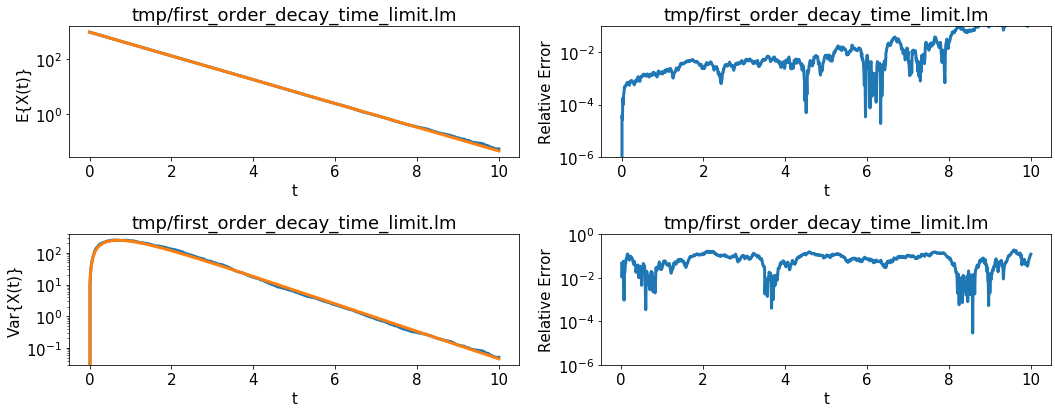

[first_order_decay_time_limit_nrm]                           : passed.


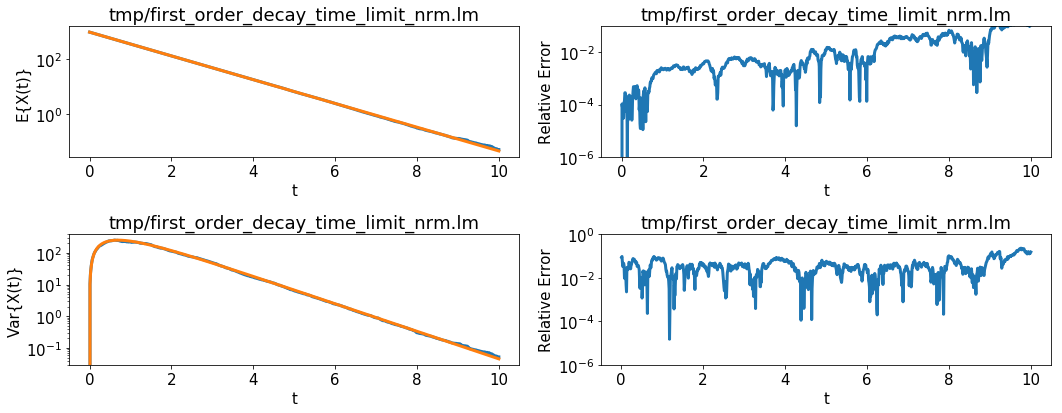

[first_order_decay_time_limit_degree_advancement]            : passed.


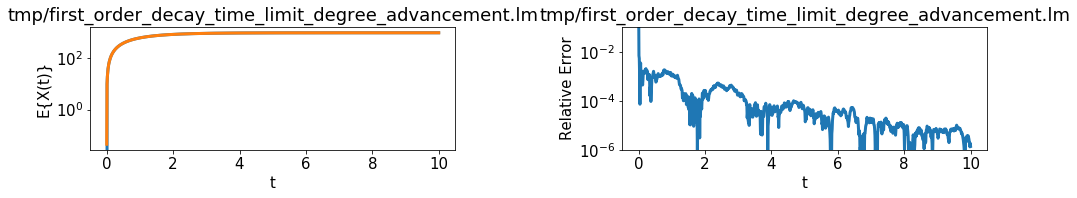

[first_order_decay_lower_species_limit]                      : passed.


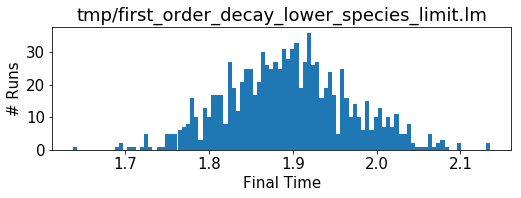

[first_order_decay_fpt_tracking]                             : passed.


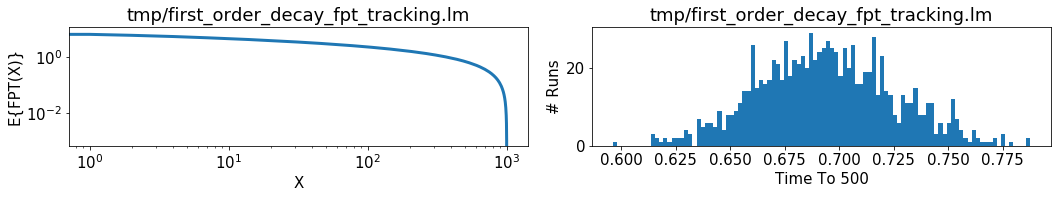

[first_order_decay_order_parameter]                          : passed.


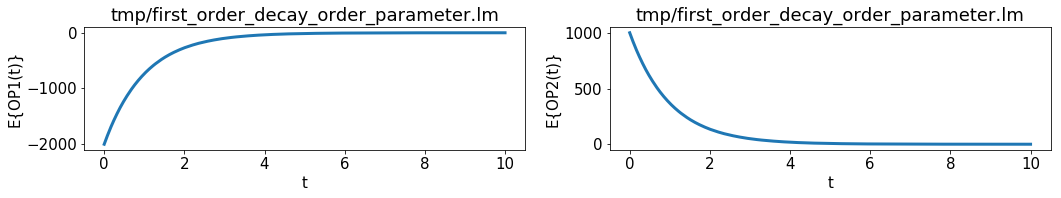

[first_order_decay_multiple_work_units]                      : passed.


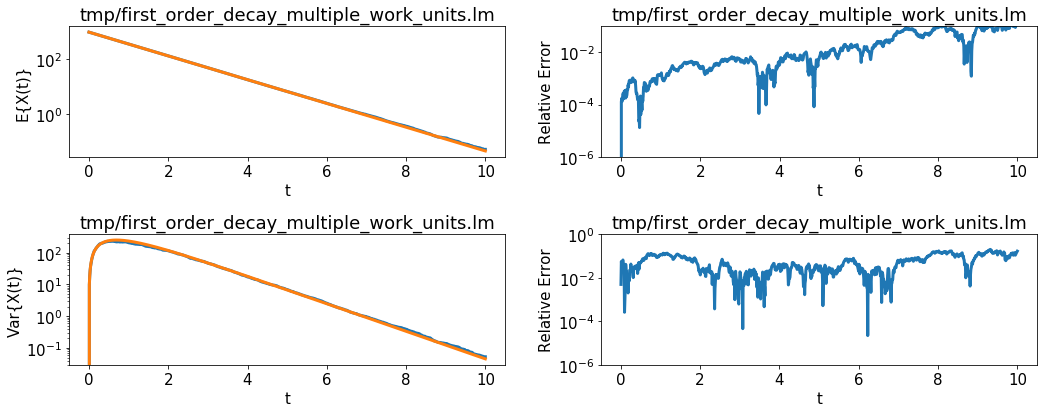

[first_order_decay_species_barrier]                          : passed.


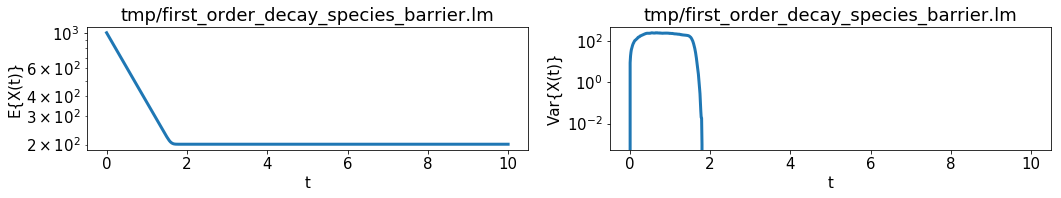

[first_order_decay_order_parameter_barrier_0]                : passed.


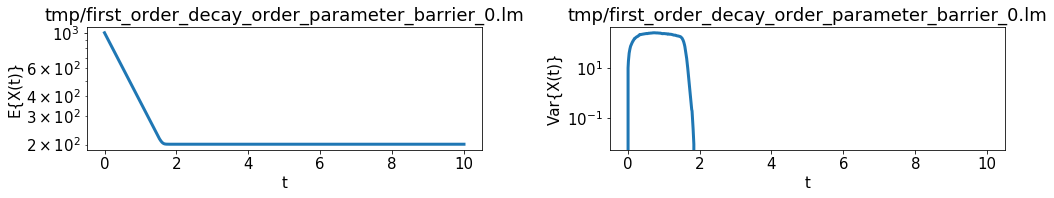

[first_order_decay_order_parameter_barrier_1]                : passed.


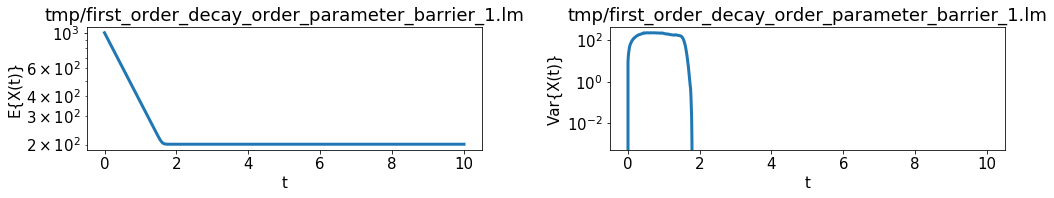

In [90]:
testMethods = {
               "first_order_decay_time_limit": test_first_order_decay_time_limit,
               "first_order_decay_time_limit_degree_advancement": test_first_order_decay_time_limit_degree_advancement,
               "first_order_decay_lower_species_limit": test_first_order_decay_lower_species_limit,
               "first_order_decay_fpt_tracking": test_first_order_decay_fpt_tracking,
               "first_order_decay_order_parameter": test_first_order_decay_order_parameter,
               "first_order_decay_multiple_work_units": test_first_order_decay_time_limit,
               "first_order_decay_time_limit_nrm": test_first_order_decay_time_limit_nrm,
               "first_order_decay_species_barrier": test_first_order_decay_barrier,
               "first_order_decay_order_parameter_barrier_0": test_first_order_decay_barrier,
               "first_order_decay_order_parameter_barrier_1": test_first_order_decay_barrier,
              }
matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (20,5*len(testNames))})
i=1
for testName in testNames:
    try:
        testOutputFilename="tmp/%s.lm"%(testName)
        testMethods[testName](testOutputFilename)
    except Exception as e:
        print "%-60s : FAILED with:"%("["+testName+"]"),e
    except:
        print "%-60s : FAILED with: Unknown exception"%("["+testName+"]")
    else:
        print "%-60s : passed."%("["+testName+"]")
    plt.tight_layout()
    plt.show()
pass

In [91]:
%%bash
rm -rf tmp